In [99]:
from pyproj import Transformer 

In [100]:
transformer = Transformer.from_crs(4326, 3174)
x, y = transformer.transform(80, 70)

In [101]:
transformer.transform(43.067728,-89.412681)

(596853.3445800609, 734093.9318319053)

In [102]:
import pandas as pd
df = pd.DataFrame({'lat':[70,80,90], 'lon':[80,90,100], 'c':[1,2,3]})
for i in range(len(df)):
    x,y = transformer.transform(df.iloc[i]['lat'], df.iloc[i]['lon'])
    df.iloc[i]['lat'] = x
    df.iloc[i]['lon'] = y
df

,lat,lon,c
0,4256795,8939017,1
1,3369164,8882795,2
2,-1083528,8729320,3


In [103]:
from zipfile import ZipFile
with ZipFile("mygtfs.zip") as zf:
    with zf.open("stops.txt") as f:
        data = pd.read_csv(f)
data.at[0, 'stop_lat'] = 20
data

,stop_id,stop_name,stop_lat,stop_lon
0,1,start1,20.000000,-89.412681
1,2,start2,43.070048,-89.409206
2,3,start3,43.073183,-89.409034
3,4,start4,43.073339,-89.400752
4,5,start5,43.073183,-89.394014
5,6,start6,43.076694,-89.389003
6,7,start7,43.087586,-89.373383
7,8,start8,43.094058,-89.362203
8,9,start9,43.100466,-89.354070


In [2]:
from pathlib import Path

import os, sys
from geopy.geocoders import GoogleV3, Nominatim
import geopandas as gpd
import pandas as pd

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim
from SCanalyzer.busSim.manager import LocalManager
from shapely.geometry import Point
from matplotlib.lines import Line2D

manger init
mangager register
mangager register


In [3]:
%matplotlib inline

In [4]:
DATA_PATH = "mygtfs.zip"
OUT_PATH = "/tmp/output"
DAY = "monday"

#FIXME:
#changed start time from 12:00:00 to 05:00:00 to match the stop_times.txt
START_TIME = "04:55:00"
ELAPSE_TIME = "01:50:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 12
city = gpd.read_file("../data/plot/background/madison-shp").to_crs(epsg=3174)
lakes = gpd.read_file("../data/plot/background/water-shp").to_crs(epsg=3174)
street = gpd.read_file("../data/plot/background/street-shp").to_crs(epsg=3174)
max_lon = city.bounds.maxx.max()
min_lon = city.bounds.minx.min()
max_lat = city.bounds.maxy.max()
min_lat = city.bounds.miny.min()

sc = SCanalyzer(DATA_PATH)

geolocator = Nominatim(user_agent="wisc_bazarr_demo")
manager = LocalManager(DATA_PATH, OUT_PATH, None)
busSim = BusSim(manager, DAY, START_TIME, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)

In [5]:
cache = {}
def geocode(addr):
    if not "madison" in addr.lower():
        addr += ", Madison WI"
    if not addr in cache:
        cache[addr] = geolocator.geocode(addr)
    return cache[addr]

In [6]:
def flatten(s):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union])})

In [19]:
gdf = None
def plot(starts=[]):      
    ax = lakes.boundary.plot(color="lightblue", zorder=1, linewidth=2, figsize=(16, 16))
    lakes.plot(color="lightblue", ax=ax, alpha=0.2, zorder=1)
    city.plot(color="black", alpha=0.05, ax=ax, zorder=2)
    street.plot(color="black", alpha=0.03, ax=ax, zorder=3)

    leg_lines = []
    leg_text = []
    
    colors = ["orange", "blue", "green", "yellow"]
    
    zorder = 4
    
    bubbles = []
    for i, addr in enumerate(starts):
        global gdf
        print(addr)
        zorder += 10
        location = geocode(addr)
        lat, lon = (location.latitude, location.longitude)
        # # check if the point is indeed in Madison
        # if lat > max_lat or lat < min_lat or lon > max_lon or lon < min_lon:
        #     print(lat, lon)
        #     print(f"Looks like {start} is not in madison.")
        #     continue
        # gdf = busSim.get_gdf()
        gdf = busSim.get_gdf(start_point=(lat, lon))
        if gdf is None:
            print(f'illegal start {addr}')
            continue
        gdf = gdf.to_crs(epsg=3174)
        
        color = colors[i % len(colors)]
        bubble = flatten(gdf.difference(lakes.unary_union))
        bubble["color"] = color
        bubbles.append(bubble)
        bubble.boundary.plot(color=color, ax=ax, linewidth=2, zorder=zorder+2)
        gdf["geometry"].centroid.plot(color="black", ax=ax, markersize=2, zorder=zorder+3)
        start = gpd.GeoSeries([Point(lon, lat)],crs=4326).to_crs(3174)
        start.plot(ax = ax, marker='o', color="black", markersize=160, zorder=100)
        
        leg_lines.append(Line2D([0], [0], color=color, lw=4))
        leg_text.append(addr)
        
    df = pd.concat(bubbles)
    df.plot(alpha=0.2, ax=ax, color=df["color"], zorder=zorder)

    leg = ax.legend(leg_lines, leg_text, prop={"size": 18}, loc="upper left")
    leg.get_frame().set_facecolor("white")
    leg.get_frame().set_edgecolor("white")

    return bubbles
    # ax.set_axis_off()
    
def demo(addrs_str):
    return plot([s.strip() for s in addrs_str.split("\n") if s.strip() != ""])

330 N Orchard St


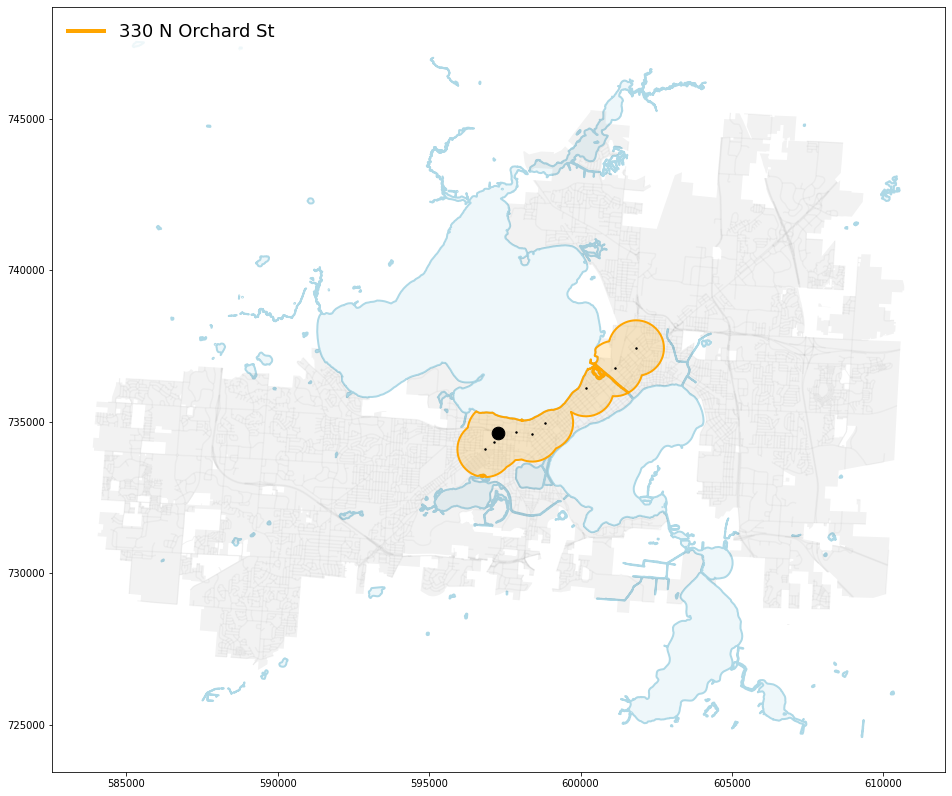

In [20]:
bubbles = demo("""
330 N Orchard St
""")

In [21]:
bubbles[0].geometry.area

0    1.114009e+07
dtype: float64

In [ ]:
DATA_PATH = "mygtfs.zip"
OUT_PATH = "/tmp/output"
DAY = "monday"

START_TIME = "04:55:00"
ELAPSE_TIME = "01:50:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 12

def gen_busSim(data_path=DATA_PATH, out_path=OUT_PATH, day=DAY, start_time=START_TIME, elapse_time=ELAPSE_TIME, avg_walking_speed=AVG_WALKING_SPEED, max_walking_min=MAX_WALKING_MIN):
    sc = SCanalyzer(data_path)
    manager = LocalManager(data_path, out_path, None)
    busSim = BusSim(manager, day, start_time, elapse_time, avg_walking_speed, max_walking_min)
    return busSim


In [27]:
start_location = "330 N Orchard St"
def get_area(start_point=None, start_location=None, busSim=None, crs=3174):
    location = geocode(start_location)
    lat, lon = (location.latitude, location.longitude)
    gdf = busSim.get_gdf(start_point=(lat, lon))
    gdf = gdf.to_crs(epsg=3174)
    bubble = flatten(gdf.geometry)
    return bubble.geometry.area

get_area(start_location=start_location, busSim=busSim)

0    1.335049e+07
dtype: float64